# **A DT framework for civil engineering structures**.
Railway bridge test-case.

In [1]:
# Importing / installing auxiliary libraries
import sys
import os

! git clone --quiet https://github.com/mtezzele/digital-twin-SHM.git > /dev/null

from IPython.display import clear_output as clc
clc()
print("Notebook ready.")

Notebook ready.


In [2]:
%cd /content/digital-twin-SHM/bridge

/content/digital-twin-SHM/bridge


In [3]:
# Importing and installing packages
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

from pathlib import Path
from tensorflow import keras
keras.backend.clear_session()

import numpy as np
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt

! pip install daft==0.1.2
! pip install pgmpy==0.1.20
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import DBNInference

from plotters.plotter import Plot

In [4]:
plt.rcParams["mathtext.fontset"] = "cm"

rnd.seed(40)
np.random.seed(40)

In [5]:
def normalize_cpd(matrix):
    # normalizes the cpd table so that each column of values sums to 1
    col_sums = matrix.sum(axis=0, keepdims=True)
    return matrix / col_sums

class GetSetup:
    """
    Get Setup class. Create the probabilistic graphical model from input information.

    :cvar numpy.ndarray states_list: list of all the possible states.
    :cvar numpy.ndarray actions_list: list of all the possible actions.
    :cvar int n_classes: number of possible damage classes.
    :cvar int n_level_step: number of intervals resulting from the discretization
        of damage level.
    :cvar numpy.ndarray conf_mat_dt: cpd associated with the digital state estimation.

    :param numpy.ndarray states_list: list of all the possible states.
    :param numpy.ndarray actions_list: list of all the possible actions.
    :param int n_classes: number of possible damage classes.
    :param int n_level_step: number of intervals resulting from the discretization
        of damage level.
    :param numpy.ndarray conf_mat_dt: cpd associated with the digital state estimation.
    """
    def __init__(self,
                 states_list,
                 actions_list,
                 n_class,
                 n_level_step,
                 conf_mat_dt):
        self.states_list = states_list
        self.actions_list = actions_list
        self.n_class = n_class
        self.n_level_step = n_level_step
        self.conf_mat_dt = conf_mat_dt

    def _get_low_diag_transition(self, prob_adv):
        """
        Returns a lower diagonal transition matrix under a first-order Markovian
        assumption and of a single state deterioration. It is assumed that damage
        may start with any magnitude and grow with one-step increments. It is
        also assumed an equal probability of transition for the undamaged and
        damaged configurations, without possibility of damage in multiple zones.

        :param float prob_adv: transition probability.
        :return: transtion matrix.
        :return type: numpy.ndarray.
        """
        n_states = self.states_list.shape[0]
        trans = np.zeros((n_states, n_states))
        # probability to stay in the undamaged condition
        trans[0, 0] = 1 - (prob_adv * (self.n_class-1))
        # probability to develop damage in an undamaged region
        trans[1:n_states:self.n_level_step, 0] = prob_adv
        for i in range(1, n_states):
            if i % self.n_level_step == 0:
                trans[i, i] = 1.
            else:
                trans[i, i] = 1 - prob_adv
                trans[i+1, i] = prob_adv
        return trans

    def _get_restart_trainsition(self):
        """
        Returns a transition matrix for the perfect maintenace action.

        :return: transtion matrix.
        :return type: numpy.ndarray.
        """
        trans = np.zeros((self.states_list.shape[0], self.states_list.shape[0]))
        trans[0, :] = 1.
        return trans

    def _get_combined_transition(self, t1, t2):
        """
        Combines two cpds. This serves to combine cpds definining the conditioning
        of a common variable on different variables.

        :param numpy.ndarray t1: first cpd.
        :param numpy.ndarray t2: second cpd.
        :return: joint cpd.
        :return type: numpy.ndarray.
        """
        n_states = t1.shape[0]
        card_1 = t1.shape[1]
        card_2 = t2.shape[1]
        comb = np.zeros((n_states, card_1*card_2))
        for i in range(n_states):
            for j in range(card_1):
                for k in range(card_2):
                    comb[i, j*n_states+k] = t1[i, j] * t2[i, k]

        # normalizes the cpd table so that each column of values sums to 1
        return normalize_cpd(comb)

    def get_transitions(self,p_nothing,p_restricted):
        """
        Returns the transition matrix for each possible action. The transition
        probabilities are an internal model of how the structural health is
        expected to evolve, depending on which action is executed.

        :param float p_nothing: assumed probability to develop damage in each
            region separately; once developed, damage has the same probability to
            grow but cannot can not spread over other regions.
        :param float p_restricted: in the same spirit of "p_nothing" this is the assumed
            probability to develop damage in each region separately and subsequent
            grow, yet in the case of restricted operational conditions.
        :return: concatenation of the transition matrices for each possible action.
        :return type: numpy.ndarray.
        """

        # p(D_t | D_t-1, U_t-1=do_nothing):
        trans_prob_nothing = self._get_low_diag_transition(prob_adv=p_nothing)

        # p(D_t | D_t-1, U_t-1=perfect_repair):
        trans_prob_perfect = self._get_restart_trainsition()

        # p(D_t | D_t-1, U_t-1=restrict_operations):
        trans_prob_restrcited = self._get_low_diag_transition(prob_adv=p_restricted)

        return np.stack((trans_prob_nothing,
                         trans_prob_perfect,
                         trans_prob_restrcited), 0)

    def get_graph(self, cpd_d_to_u, transitions):
        """
        Returns all the structures required to create the main graph and the
        prediction subgraph, and the associated cpds.

        :param numpy.ndarray cpd_d_to_u: cpd encoding a deterministic policy.
        :param transitions: stack of the transition matrices for each action.
        :return: nodes and edges defining the main graph;
                 nodes and edges defining the prediction subgraph;
                 cpds associated with the main graph;
                 cpds associated with the prediction subgraph.
        :return type: list; list; list; list.
        """
        states = self.states_list
        Ns = states.shape[0]
        actions = self.actions_list
        Na = actions.shape[0]

        # nodes and edges defining the graph
        # e.g. ((node_1, time_slice(node_1)), (node_2, timeslice(node_2)))
        graph_structure = ([(('U^{A}_{-1}', 0), ('D', 0)),
                            (('D_{NN}', 0), ('D', 0)),
                            (('D', 0), ('U^{P}', 0)),
                            (('D', 0), ('D', 1)),
                            (('U^{A}_{-1}', 1), ('D', 1)),
                            (('D_{NN}', 1), ('D', 1)),
                            (('D', 1), ('U^{P}', 1)),])

        # nodes and edges defining the prediction subgraph
        digital_subgraph = ([(('D', 0), ('U', 0)),
                             (('D', 0), ('D', 1)),
                             (('U', 0), ('D', 1)),
                             (('D', 1), ('U', 1))])

        # p(D_t | D_t-1, U_t-1=do_nothing)
        cond_d_nothing = self._get_combined_transition(t1=self.conf_mat_dt,t2=transitions[0])

        # p(D_t | D_t-1, U_t-1=perfect_repair)
        cond_d_perfect = self._get_combined_transition(t1=self.conf_mat_dt,t2=transitions[1])

        # p(D_t | D_t-1, U_t-1=restrict_operations)
        cond_d_restricted = self._get_combined_transition(t1=self.conf_mat_dt,t2=transitions[2])

        cond_d = np.concatenate((cond_d_nothing,
                                 cond_d_perfect,
                                 cond_d_restricted), 1)

        # conditional probability tables to be associated with the model. Each CPD
        # should be an instance of `TabularCPD`. Note that while adding variables and
        # the evidence, nodes have to be of the form (node_name, time_slice)
        U_a_0_cpd = TabularCPD(('U^{A}_{-1}', 0),
                               Na,
                               np.ones((Na, 1)),
                               state_names={('U^{A}_{-1}', 0): actions.tolist()})

        D_NN_0_cpd = TabularCPD(('D_{NN}', 0),
                                Ns,
                                np.ones((Ns, 1)),
                                state_names = {('D_{NN}', 0): states.tolist()})

        D_0_cpd = TabularCPD(('D', 0),
                             Ns,
                             np.concatenate((self.conf_mat_dt,
                                             transitions[1],
                                             self.conf_mat_dt),1),
                             evidence=[('U^{A}_{-1}', 0),('D_{NN}', 0)],
                             evidence_card=[Na, Ns],
                             state_names={('D', 0): states.tolist(),
                                          ('U^{A}_{-1}', 0): actions.tolist(),
                                          ('D_{NN}', 0): states.tolist()})

        U_p_0_cpd = TabularCPD(('U^{P}', 0),
                               Na,
                               cpd_d_to_u,
                               evidence=[('D', 0)],
                               evidence_card=[Ns],
                               state_names={('U^{P}', 0): actions.tolist(),
                                            ('D', 0): states.tolist()})

        D_0_sub_cpd = TabularCPD(('D', 0),
                                 Ns,
                                 np.ones((Ns, 1)),
                                 state_names={('D', 0): states.tolist()})

        U_0_sub_cpd = TabularCPD(('U', 0),
                                 Na,
                                 cpd_d_to_u,
                                 evidence=[('D', 0)],
                                 evidence_card=[Ns],
                                 state_names={('U', 0): actions.tolist(),
                                              ('D', 0): states.tolist()})

        U_a_1_cpd = TabularCPD(('U^{A}_{-1}', 1),
                               Na,
                               np.ones((Na, 1)),
                               state_names={('U^{A}_{-1}', 1): actions.tolist()})

        D_NN_1_cpd = TabularCPD(('D_{NN}', 1),
                                Ns,
                                np.ones((Ns, 1)),
                                state_names = {('D_{NN}', 1): states.tolist()})

        D_1_cpd = TabularCPD(('D', 1),
                             Ns,
                             cond_d,
                             evidence=[('U^{A}_{-1}', 1),('D_{NN}', 1),('D', 0)],
                             evidence_card=[Na,
                                            Ns,
                                            Ns],
                             state_names={('D', 1): states.tolist(),
                                          ('U^{A}_{-1}', 1): actions.tolist(),
                                          ('D_{NN}', 1): states.tolist(),
                                          ('D', 0): states.tolist()})

        U_p_1_cpd = TabularCPD(('U^{P}', 1),
                               Na,
                               cpd_d_to_u,
                               evidence=[('D', 1)],
                               evidence_card=[Ns],
                               state_names={('U^{P}', 1): actions.tolist(),
                                            ('D', 1): states.tolist()})

        D_1_sub_cpd = TabularCPD(('D', 1),
                                 Ns,
                                 np.concatenate(np.array([transitions[i] for i
                                                          in range(Na)]),1),
                                 evidence=[('U', 0),('D', 0)],
                                 evidence_card=[Na, Ns],
                                 state_names={('D', 1): states.tolist(),
                                              ('U', 0): actions.tolist(),
                                              ('D', 0): states.tolist()})

        U_1_sub_cpd = TabularCPD(('U', 1),
                                 Na,
                                 cpd_d_to_u,
                                 evidence=[('D', 1)],
                                 evidence_card=[Ns],
                                 state_names={('U', 1): actions.tolist(),
                                              ('D', 1): states.tolist()})

        list_cpd_graph = [U_a_0_cpd, D_NN_0_cpd, D_0_cpd, U_p_0_cpd,
                          U_a_1_cpd, D_NN_1_cpd, D_1_cpd, U_p_1_cpd]
        list_cpd_subgraph = [D_0_sub_cpd, U_0_sub_cpd, D_1_sub_cpd, U_1_sub_cpd]

        return graph_structure, digital_subgraph, list_cpd_graph, list_cpd_subgraph

In [6]:
class PhysicalAsset:
    """
    Physical Asset class. The physical asset and its dynamic evolution are described
    through a parametric model that mimics the behavior of an instrumented
    physical system. It plays the physical counterpart of the digital twin.

    :cvar str path_data: path associated with the working directory.
    :cvar numpy.ndarray state: ground truth (unknown) physical state: [damage class,
        damage level].
    :cvar bool restricted: boolean for restricted operational conditions.
    :cvar numpy.ndarray X_classifier: observations dataset for the classifer
        --> damage class.
    :cvar numpy.ndarray X_regressors: observations dataset for the regressors
        --> damage level.
    :cvar numpy.ndarray labels_class: damage class labels associated with the
        observations.
    :cvar numpy.ndarray labels_level: damage level labels associated with the
        observations.
    :cvar numpy.ndarray labels_pressure: axle mass [ton] labels associated with
        the observations.
    :cvar numpy.ndarray labels_velocity: train velocity [km/h] labels associated
        with the observations.
    :cvar int n_classes: number of possible damage classes.
    :cvar int degradation_law: transition type for the evolution of the physcal state.
    :cvar int degradation_steps: degradation step advancing the evolution of the
        physical state.

    :param str path_data: path associated with the working directory.
    :param str degradation_law: transition type for the evolution of the physcal
        state. It can an be "custom" or "stochastic".
    """
    def __init__(self, path_data, degradation_law):
        self.path_data = path_data
        self.state = None
        self.restricted = None
        self.X_classifier = None
        self.X_regressors = None
        self.labels_class = None
        self.labels_level = None
        self.labels_pressure = None
        self.labels_velocity = None # not used
        self.n_classes = None
        self.degradation_law = degradation_law
        self.degradation_steps = None

    def generate_observations(self):
        """
        Load a dataset with recordings simulated for different operational and
        damage conditions. The same dataset of observations is loaded a number
        of times equal to the number of SHM models, because each SHM model needs
        a specific data normalization. Also load the corresponding labels.
       """
        self.labels_class = np.load(Path(self.path_data + 'labels_class.npy'))
        self.labels_level = np.load(Path(self.path_data + 'labels_level.npy'))
        self.labels_pressure = np.load(Path(self.path_data + 'labels_pressure.npy'))
        self.labels_velocity = np.load(Path(self.path_data + 'labels_velocity.npy'))
        self.X_classifier = np.load(Path(self.path_data + 'recordings_classifier_1of2.npy'))
        self.X_classifier = np.append(self.X_classifier, np.load(Path(
            self.path_data + 'recordings_classifier_2of2.npy')), 0)
        self.X_regressors = np.load(Path(self.path_data + 'recordings_regressors_1of12.npy'))
        for i in range(2,13):
            self.X_regressors = np.append(self.X_regressors, np.load(Path(
                self.path_data + 'recordings_regressors_' + str(i) + 'of12.npy')), 1)
        self.n_classes = np.unique(self.labels_class).shape[0]
        self.degradation_steps = -1

    def get_observations(self, n_obs):
        """
        Returns a batch of n_obs observations in the database for the current
        physical state. Observations are returned for each SHM model, as each
        of these models requires a specific data normalization.

        :param int n_obs: number of observations in the batch to be returend.
        :return: numpy.ndarray containing the observation for the classifer;
                 numpy.ndarray containing an array of observations, each one
                     normalized for a specific regressor.
        :return type: numpy.ndarray, numpy.ndarray.
        """

        # check the data entries with the required damage class
        check_class = self.labels_class == self.state[0]
        # check the data entries with the required train weight (below 18 ton per axle)
        if self.restricted:
            check_also_train = np.logical_and(self.labels_class == self.state[0], self.labels_pressure <= 18.)
        if self.restricted:
            # get indexes of data entries satisfying the check_class and check_train condtions
            indexes = np.where(check_also_train)[0]
        else:
            # get indexes of data entries satisfying the check_class condtion
            indexes = np.where(check_class)[0]
        # get the index of the valid data entries with the labels_level closest to p_state[1]
        distances = np.abs(self.labels_level[indexes] - self.state[1])
        closest_indeces = np.argsort(distances)
        obs_idx = indexes[closest_indeces[:n_obs]]
        norm_obs = np.array([self.X_regressors[i][obs_idx] for i in range(self.n_classes-1)])
        return self.X_classifier[obs_idx], norm_obs

    def update_physical_state(self, action):
        """
        Update the physical state given the current p_state and an action.

        :param int action: identifier of the action ruling the physical state update.
            0 --> "do_nothing" decision.
            1 --> "perfect_repair" decision.
            2 --> "restrict_operations" decision.
        """
        # the digital state is estimated the first time for degradation_steps=0
        self.degradation_steps += 1

        # assume normal operational conditions after a maintenance action
        if action == "do_nothing" or action == "perfect_repair":
            self.restricted = 0
        elif action == "restrict_operations":
            self.restricted = 1

        # if perfect repair restart intial condition
        if action == "perfect_repair":
            self.degradation_steps = 0

        # assume the undamaged configuration as the initial one
        if self.degradation_steps == 0:
            self.state = np.array([0, 0.30])

        else:
            if self.degradation_law == "custom":
                if action == "do_nothing" or action == "restrict_operations":
                    if self.state[0] == 0:
                        self.state[0] = 4
                        self.state[1] = 0.31
                    else:
                        self.state[1] = np.array([0.31, 0.31, 0.32, 0.33, 0.34, 0.36, 0.37, 0.38, 0.39,
                                                  0.40, 0.41, 0.42, 0.43, 0.44, 0.46, 0.47, 0.48, 0.49,
                                                  0.50, 0.51, 0.52, 0.53, 0.54, 0.56, 0.57, 0.58, 0.59,
                                                  0.60, 0.61, 0.62, 0.63, 0.64, 0.66, 0.67, 0.68, 0.69,
                                                  0.70, 0.71, 0.72, 0.73, 0.74, 0.76, 0.77, 0.78])[self.degradation_steps]

            elif self.degradation_law == "stochastic":
                if action == "do_nothing":
                    if self.state[0] == 0:
                        # undamaged case, toss the coin to damage
                        if rnd.randrange(2):
                            self.state[0] = 1 + rnd.randrange(self.n_classes-1)
                            self.state[1] = np.random.uniform(low=0.3, high=0.35)
                    else:
                        self.state[1] += np.max((0.,np.random.normal(0.015, 0.01)))

                elif action == "restrict_operations":
                    if self.state[0] == 0:
                        # undamaged case, toss a coin with 4 faces to damage
                        if not rnd.randrange(4):
                            self.state[0] = 1 + rnd.randrange(self.n_classes-1)
                            self.state[1] = np.random.uniform(low=0.3, high=0.35)
                    else:
                        self.state[1] += np.max((0.,np.random.normal(0.0095, 0.005)))

In [7]:
class DigitalAsset:
    """
    Digital Asset class. The digital asset is described by those parameters
    underlying the computational models comprising the digital twin.

    :cvar tensorflow.python.keras.engine.functional.Functional classifier: SHM
        damage localization model.
    :cvar list regressors: SHM damage quantification models, one for each class.
    :cvar numpy.ndarray statistics_level: statistics used to normalize the damage
        level for each regressor.
    :cvar float d_level_discr: damage level discretization adopted to describe
        different states, related to the same damage location but different
        damage severity.
    :cvar numpy.ndarray cpd: cpd associated with the digital state estimation.
    :cvar numpy.ndarray state: estimated digital state.
    :cvar numpy.ndarray qois: quantities of interest computed for the estimated
        digital state.

    :param tensorflow.python.keras.engine.functional.Functional classifier: SHM
        damage localization model.
    :param list regressors: SHM damage quantification models, one for each class.
    :param numpy.ndarray statistics_level: statistics used to normalize the
        damage level for each regressor.
    :param float d_level_discr: damage level discretization adopted to describe
        different states, related to the same damage location but different
        damage severity.
    :param numpy.ndarray cpd: cpd associated with the digital state estimation.
    """
    def __init__(self, classifier, regressors, statistics_level, d_level_discr, cpd=np.diag(np.ones((37)))):
        self.classifier = classifier
        self.regressors = regressors
        self.statistics_level = statistics_level
        self.d_level_discr = d_level_discr
        self.cpd = cpd
        self.state = None
        self.qois = None # not used

    def estimate_state(self, obs_classifier, obs_regressors):
        """
        Takes the observations and estimates the current digital state.

        :param numpy.ndarray obs_classifier: observation for the classifer.
        :param numpy.ndarray obs_regressors: array of observations, each one
            normalized for a specific regressor.
        """
        # estimate the damage class
        damage_class = np.argmax(self.classifier(obs_classifier).numpy(), axis=1)
        # take the most frequent class over the batch of observations
        values, counts = np.unique(damage_class, return_counts=True)
        damage_class = values[np.argmax(counts)]

        # if undamaged case, damage_level can be set to zero
        if damage_class == 0:
            damage_level = 0
        else:
            # if the presence of damage is detected, estimate damage_level by
            # averaging over the batch of observations
            damage_level = np.mean(self.regressors[damage_class-1](
                obs_regressors[damage_class-1]).numpy())
            # restore the unnormalized value of damage_level
            damage_level = damage_level * self.statistics_level[1][damage_class-1] \
                + self.statistics_level[0][damage_class-1]
            # estimated damage_level is rounded to the required discretization step
            damage_level = np.around(damage_level*0.1/self.d_level_discr, 1) \
                *self.d_level_discr/0.1

        self.state = np.array([damage_class, damage_level])

    def compute_qois(self):
        """
        Compute the quantities of interest.
        """
        pass

In [8]:
class Planner:
    """
    Planner class. This serves to obtain a deterministic policy for optimal control.

    :cvar numpy.ndarray states_list: list of all the possible states.
    :cvar numpy.ndarray actions_list: list of all the possible actions.
    :cvar float gamma: discount factor.
    :cvar transitions: concatenation of the transition matrices for each action.
    :cvar numpy.ndarray policy: matrix encoding a deterministic policy.

    :param numpy.ndarray states_list: list of all the possible states.
    :param numpy.ndarray actions_list: list of all the possible actions.
    :param float gamma: discount factor.
    :param transitions: stack of the transition matrices for each action.
    """

    def __init__(self, states_list, actions_list, gamma, transitions):
        self.states_list = states_list
        self.actions_list = actions_list
        self.gamma = gamma
        self.transitions = transitions
        self.policy = None

    def compute_reward(self, state, action):
        """
        Compute a reward that quantifies overall performance of the asset-twin system.

        :param str state: digital state.
        :param str action: enacted action.
        :return: computed reward.
        :return type: float.
        """
        alpha_health = 2.5
        alpha_action = 2.5

        def r_health(state):
            """
            Compute a reward associated with the health state of the asset.

            :param str state: digital state.
            :return: computed reward.
            :return type: float.
            """
            delim = state.find(';')
            loc_damage = int(state[:delim])
            liv_damage = float(state[delim+1:])
            if loc_damage == 0:
                r_health = 0
            else:
                r_health = 4 - np.exp(5*liv_damage)
                if liv_damage >= 0.79:
                    r_health = -250
            return r_health

        def r_action(action):
            """
            Compute a reward  associated with the cost of the enacted actions.

            :param str action: enacted action.
            :return: computed reward.
            :return type: float.
            """
            if action == "do_nothing":
                r_action = 30.
            elif action =="perfect_repair":
                r_action = -250.
            elif action == "restrict_operations":
                r_action = 27

            return r_action

        return alpha_health*r_health(state) + alpha_action*r_action(action)


    def compute_policy(self, maxit, tol):
        """
        Value iteration algorithm to compute a policy.

        :param int maxit: number of allowed iterations.
        :param float tol: small positive tolerance.
        """
        Ns = self.states_list.shape[0]
        Na = self.actions_list.shape[0]

        # P represents the transition probabilities of the environment
        # P[s][a] is a list of transition tuples (prob, next_state, reward)
        P = np.empty((Ns, Na, Ns), dtype=object)
        for i in range(Ns): #current state
            for j in range(Na): #current action
                for k in range(Ns): #next state
                    p = self.transitions[j, k, i]
                    r = self.compute_reward(self.states_list[k], self.actions_list[j])
                    P[i, j, k] = p, k, r

        P = P.tolist()


        def one_step_lookahead(state, V):
            """
            Helper function to calculate the value for all actions in a given state.

            :param int state: the state to consider.
            :param numpy.ndarray V: the value to use as an estimator (of length Ns).
            :return: vector of length Na with the expected value of each action.
            :return type: numpy.ndarray.
            """
            A = np.zeros(Na)
            for a in range(Na):
                for prob, next_state, reward in P[state][a]:
                    A[a] += prob * (reward + self.gamma * V[next_state])
            return A

        V = np.zeros(Ns)
        i = 0
        while True:
            i += 1
            # Stopping condition
            delta = 0
            # Update each state...
            for s in range(Ns):
                # Do a one-step lookahead to find the best action
                A = one_step_lookahead(s, V)
                best_action_value = np.max(A)
                # Calculate delta across all states seen so far
                delta = max(delta, np.abs(best_action_value - V[s]))
                # Update the value function. Ref: Sutton book eq. 4.10
                V[s] = best_action_value
            # Check if we can stop
            if delta < tol:
                print('value iteration converged after {} iterations'.format(i))
                break
            if i > maxit:
                print('value iteration not converged after {} iterations'.format(maxit))
                break

        # Create a deterministic policy using the optimal value function
        policy = np.zeros([Ns, Na])
        for s in range(Ns):
            # One step lookahead to find the best action for this state
            A = one_step_lookahead(s, V)
            best_action = np.argmax(A)
            # Always take the best action
            policy[s, best_action] = 1.0

            self.policy = policy

In [9]:
class Graph:
    """
    Graph class. A graphical model structure that describes the interactions
    between the elements comprising the physical and digital assets.

    :cvar PhysicalAsset physical_asset: physical twin.
    :cvar DigitalAsset digital_asset: digital twin.
    :cvar numpy.ndarray states_list: list of all the possible states.
    :cvar numpy.ndarray actions_list: list of all the possible actions.
    :cvar pgmpy.models.DynamicBayesianNetwork dbn: dynamic Bayesian network adopted
        to describe the graphical model.
    :cvar pgmpy.models.DynamicBayesianNetwork dbn_predict: dynamic Bayesian network
        adopted to describe the prediction subgraph.
    :cvar pandas.DataFrame hist_var: values history for the variables in the graph.
    :cvar pandas.DataFrame hist_d_state_prob: history of the digital state probabilities
    :cvar pandas.DataFrame hist_actions_prob: history of the actions probabilities
    :cvar int time_index: time index counting the total elaplsed graph time slices.
    :cvar Planner planner: optimal control, from digital state to actions.

    :param PhysicalAsset physical_asset: physical twin.
    :param DigitalAsset digital_asset: digital twin.
    :param numpy.ndarray states_list: list of all the possible states.
    :param numpy.ndarray actions_list: list of all the possible actions.
    :param Planner planner: optimal control too, from digital state to actions
    """
    def __init__(self,
                 physical_asset,
                 digital_asset,
                 states_list,
                 actions_list,
                 planner):
        self.physical_asset = physical_asset
        self.digital_asset = digital_asset
        self.states_list = states_list
        self.actions_list = actions_list
        self.dbn = DBN()
        self.dbn_predict = DBN()
        self.hist_var = None
        self.hist_d_state_prob = None
        self.hist_actions_prob = None
        self.time_index = None
        self.planner = planner

    def assemble_graph(self,
                       graph_structure,
                       cpd_list,
                       digital_subgraph,
                       list_cpd_subgraph,
                       plot=False):
        """
        # add nodes and edges, and associate the conditional plrobability tables
        # to the resulting graphical model.

        :param list graph_structure: list of nodes and edges in the form
            of pariwise connectivity.
        :param list cpd_list: list of conditional probability tables, each one
            being an instance of the pgmpy `TabularCPD`.
        :param list digital_subgraph: list of nodes and edges in the form
            of pariwise connectivity, for the prediction subgraph.
        :param list list_cpd_subgraph: list of conditional probability tables
            for the prediction subgraph.
        :param bool plot: if True the graph is rendered with daft.
            Defaults to False.
        """
        ### main graph ###

        # add nodes and edges for the graph
        self.dbn.add_edges_from(graph_structure)

        print(f'\nnodes in the graph: {self.dbn._nodes()}')
        print('\nintra slice edges in the graph:')
        for edge in self.dbn.get_intra_edges():
            print(edge[0], edge[1])
        print('\ninter slice edges in the graph:')
        for edge in self.dbn.get_inter_edges():
            print(edge[0], edge[1])

        for cpd_table in cpd_list:
            # normalizes the cpd tables so that each column of values sums to 1
            # without changing the proportion between states
            cpd_table.normalize()

            # associating the parameters with the graph structure
            self.dbn.add_cpds(cpd_table)

        # checking if the sum of the probabilities in each cpd for each state
        # is one and that cpds associated with nodes are consistent with parents
        # if true continues the execution, otherwise throws an error
        self.dbn.check_model()

        if plot:
            plt.rc('font', size=7)
            # display the graphical model
            self.dbn.to_daft().render()
            plt.show()

        # initialize the time index of the graph
        self.time_index = -1

        ### prediction subgraph ###

        # add nodes and edges for the prediction subgraph
        self.dbn_predict.add_edges_from(digital_subgraph)

        print(f'\nnodes in the prediction subgraph: {self.dbn_predict._nodes()}')
        print('\nintra slice edges in the prediction subgraph: ')
        for edge in self.dbn_predict.get_intra_edges():
            print(edge[0], edge[1])
        print('\ninter slice edges in the prediction subgraph:')
        for edge in self.dbn_predict.get_inter_edges():
            print(edge[0], edge[1])

        if plot:
            self.dbn_predict.to_daft().render()
            plt.show()

        for cpd_table in list_cpd_subgraph:
            cpd_table.normalize()
            self.dbn_predict.add_cpds(cpd_table)

        # if true continues the execution, otherwise throws an error
        self.dbn_predict.check_model()


    def _find_permutation(self, state):
        """
        retrive the index of the (flattened) state from those in possible_states.

        :param numpy.ndarray state: physical or estimated digital state.
        :return: index of state in states_list.
        :return type: int.
        """
        if np.around(float(state[1]), 3) > 0.8:
            print("\nDT failed")
            sys.exit()
        state = f"{int(state[0])};{str(np.around(float(state[1]), 3))}"
        index = np.where(self.states_list == state)[0][0]
        return int(index)

    def simulate(self, n_steps, n_samples, n_obs):
        """
        physical and digital assets communicate with each other by means of the
        graphical model: this method advances this interaction in time and tracks
        the state of each variable.

        :param int n_steps: number of time steps the simulation has to be advanced
        :param int n_samples: number of samples used to describe the probability
            distribution of the digital state during the forward inference.
        :param int n_obs: batch size of the observations to be processed with the
            SHM models to estimate the digital state at each time step.
        """

        # this condition serves to intialize the graph in terms of "D_NN"
        # the initialization is done assuming a do_nothing action, observing
        # the system and estimating the digital state. This is necessary only the
        # first time this method is called, the rest of the time we have access
        # to the digital state from the last simulation and we can therefore
        # compute an optimal action to take
        if self.time_index == -1:
            self.time_index += 1
            # update the physical state by advancing the degradation of one step
            # according to the previously taken action
            self.physical_asset.update_physical_state(action="do_nothing")

            # get observations
            obs_classifier, obs_regressors = self.physical_asset.get_observations(n_obs)
            # if undamaged case, the true damage_level can be set to zero
            p_state = np.array([0., 0.])
            p_state_discr = np.array([0., 0.])
            # otheriwse retrive the corresponding discretized value
            if self.physical_asset.state[0] != 0:
                p_state[0] = self.physical_asset.state[0]
                p_state_discr[0] = self.physical_asset.state[0]
                p_state[1] = self.physical_asset.state[1]
                p_state_discr[1] = np.around(p_state[1]*0.1/self.digital_asset.d_level_discr, 1) \
                        *self.digital_asset.d_level_discr/0.1
            # estimate the digital state
            self.digital_asset.estimate_state(obs_classifier, obs_regressors)

            # apply confusion matrix to find the digital state distribution
            last_d_state_prob = self.digital_asset.cpd[:,self._find_permutation(
                                                      self.digital_asset.state)]

            # apply deterministic ploicy to get the current action probabilities
            current_action_prob = np.matmul(self.planner.policy.T,last_d_state_prob)
            # take the most likely action
            current_action = str(self.actions_list[np.argmax(current_action_prob)])

            # initialize the dataframe for the values of the variables in the graph
            # --> for d_state and previous_action we only track the MAP estimates
            self.hist_var = {
                'p_state': f"{int(p_state[0])};{str(np.around(p_state[1], 3))}",
                'p_state_discrete': self.states_list[
                    self._find_permutation(p_state_discr)
                ],
                'd_state': str(self.states_list[np.argmax(last_d_state_prob)]),
                'current_action': current_action,
            }
            self.hist_var = pd.DataFrame(self.hist_var, index=[0,])

            self.hist_d_state_prob = pd.DataFrame([last_d_state_prob.tolist()])
            self.hist_d_state_prob.columns = self.states_list.tolist()

            self.hist_actions_prob = pd.DataFrame([current_action_prob.tolist()])
            self.hist_actions_prob.columns = self.actions_list.tolist()

        # Evidence to be applied to the model. It should be a dictionary of the
        # form (variable_name, time_slice): state}
        evid = {}

        for i in range(n_steps):

            # update the time index of the graph
            self.time_index += 1

            last_action = self.hist_var.current_action[self.time_index-1]
            last_d_state_prob = self.hist_d_state_prob.loc[self.time_index-1].to_numpy()

            # update the physical state by advancing the degradation of one step
            self.physical_asset.update_physical_state(action=last_action)
            # get observations
            obs_classifier, obs_regressors = self.physical_asset.get_observations(n_obs)
            # if undamaged case, the true damage_level can be set to zero
            p_state = np.array([0., 0.])
            p_state_discr = np.array([0., 0.])
            # otheriwse retrive the corresponding discretized value
            if self.physical_asset.state[0] != 0:
                p_state[0] = self.physical_asset.state[0]
                p_state_discr[0] = self.physical_asset.state[0]
                p_state[1] = self.physical_asset.state[1]
                p_state_discr[1] = np.around(p_state[1]*0.1/self.digital_asset.d_level_discr, 1) \
                        *self.digital_asset.d_level_discr/0.1
            # estimate the digital state
            self.digital_asset.estimate_state(obs_classifier, obs_regressors)

            # simulation with evidence: advance one time_slice per time
            print(
                f'\nsimulation step = {i + 1} of {n_steps}, time index = {self.time_index}'
            )

            dbn_infer = DBNInference(self.dbn)

            # when simulate is called, the graph starts from a time slice indexed
            # by zero. Retrive the corresponding valriables value and use them
            # in the virtual evidences dictionary {(variable_name, time_slice): state}
            evid[('U^{A}_{-1}', 1)] = last_action
            evid[('D_{NN}', 1)] = self.states_list[self._find_permutation(self.digital_asset.state)]

            # only hard evidence is available in pgmpy, we smooth it by sampling
            sampled = np.random.choice(self.states_list.shape[0],
                                    size=n_samples,
                                    p=last_d_state_prob)

            last_d_state_prob = np.zeros((self.states_list.shape[0]))
            current_action_prob = np.zeros((self.actions_list.shape[0]))
            for j in range(n_samples):
                evid[('D', 0)] = self.states_list[sampled[j]]

                # exact forward inference of query_var at predict_time slices
                # in future via belief propagation (sum–product message passing)
                inf = dbn_infer.forward_inference([('D', 1),('U^{P}', 1)], evidence=evid)

                last_d_state_prob += inf[('D', 1)].values
                current_action_prob += inf[('U^{P}', 1)].values

            # normalize distributions so that sum to 1
            last_d_state_prob = normalize_cpd(last_d_state_prob)
            current_action_prob = normalize_cpd(current_action_prob)

            # take the most likely action
            current_action = str(self.actions_list[np.argmax(current_action_prob)])

            # update the dataframe for the values of the variables in the graph
            # --> for d_state and previous_action we only track the MAP estimate
            new_var = {
                'p_state': f"{int(p_state[0])};{str(np.around(p_state[1], 3))}",
                'p_state_discrete': self.states_list[
                    self._find_permutation(p_state_discr)
                ],
                'd_state': str(self.states_list[np.argmax(last_d_state_prob)]),
                'current_action': current_action,
            }

            self.hist_var = pd.concat([self.hist_var,pd.DataFrame(new_var, index=[0, ])],
                                      ignore_index = True)

            new_var = pd.DataFrame([last_d_state_prob.tolist()])
            new_var.columns = self.states_list.tolist()
            self.hist_d_state_prob = pd.concat([self.hist_d_state_prob, new_var],
                                               ignore_index = True)

            new_var = pd.DataFrame([current_action_prob.tolist()])
            new_var.columns = self.actions_list.tolist()
            self.hist_actions_prob = pd.concat([self.hist_actions_prob, new_var],
                                               ignore_index = True)

    def predict(self, n_steps, n_samples):
        """
        Future state prediction for digital asset only. Forward inference of a
        query variable in future.

        :param int n_steps: horizon for which the query variable has to be predicted.
        :param int n_samples: number of samples from the graph.
        :return: predicted probability distribution over the digital state and
            the actions at n_steps steps in future.
        :return type: pandas.DataFrame.
        """
        print('\nfuture prediction (digital asset only)')
        print(
            f'from time index = {self.time_index}, to {n_steps} time slices in future'
        )

        prob_D = np.zeros((n_steps+1, self.states_list.shape[0]))
        prob_U = np.zeros((n_steps+1, self.actions_list.shape[0]))

        # simulation with virtual/soft evidence
        evid = [[self.hist_d_state_prob.loc[self.time_index].to_list()[i]]
                for i in range(self.states_list.shape[0])]

        sim = self.dbn_predict.simulate(n_time_slices=n_steps+1, n_samples=n_samples,
            virtual_evidence=[TabularCPD(('D', 0), self.states_list.shape[0], evid)],
            show_progress=False)

        sim = sim.to_numpy()

        # extract the data and store them into dataframes
        for i in range(n_steps+1):
            for j in range(n_samples):
                prob_D[i,sim[j,2*i]] += 1
                prob_U[i,sim[j,2*i+1]] += 1

        # evolution of the probability distribution over the digital state
        prob_D = normalize_cpd(prob_D.T).T
        result_D = pd.DataFrame(prob_D.tolist())
        result_D.columns = self.states_list.tolist()

        # evolution of the probability distribution over the actions
        prob_U = normalize_cpd(prob_U.T).T
        result_U = pd.DataFrame(prob_U.tolist())
        result_U.columns = self.actions_list.tolist()

        return result_D, result_U

value iteration converged after 122 iterations

nodes in the graph: ['U^{P}', 'U^{A}_{-1}', 'D', 'D_{NN}']

intra slice edges in the graph:
(U^{A}_{-1}, 0) (D, 0)
(D, 0) (U^{P}, 0)
(D_{NN}, 0) (D, 0)

inter slice edges in the graph:
(D, 0) (D, 1)


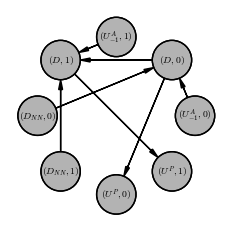


nodes in the prediction subgraph: ['D', 'U']

intra slice edges in the prediction subgraph: 
(D, 0) (U, 0)

inter slice edges in the prediction subgraph:
(D, 0) (D, 1)
(U, 0) (D, 1)


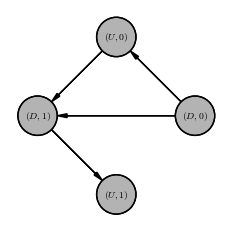


simulation step = 1 of 60, time index = 1

simulation step = 2 of 60, time index = 2

simulation step = 3 of 60, time index = 3

simulation step = 4 of 60, time index = 4

simulation step = 5 of 60, time index = 5

simulation step = 6 of 60, time index = 6

simulation step = 7 of 60, time index = 7

simulation step = 8 of 60, time index = 8

simulation step = 9 of 60, time index = 9

simulation step = 10 of 60, time index = 10

simulation step = 11 of 60, time index = 11

simulation step = 12 of 60, time index = 12

simulation step = 13 of 60, time index = 13

simulation step = 14 of 60, time index = 14

simulation step = 15 of 60, time index = 15

simulation step = 16 of 60, time index = 16

simulation step = 17 of 60, time index = 17

simulation step = 18 of 60, time index = 18

simulation step = 19 of 60, time index = 19

simulation step = 20 of 60, time index = 20

simulation step = 21 of 60, time index = 21

simulation step = 22 of 60, time index = 22

simulation step = 23 of 60,

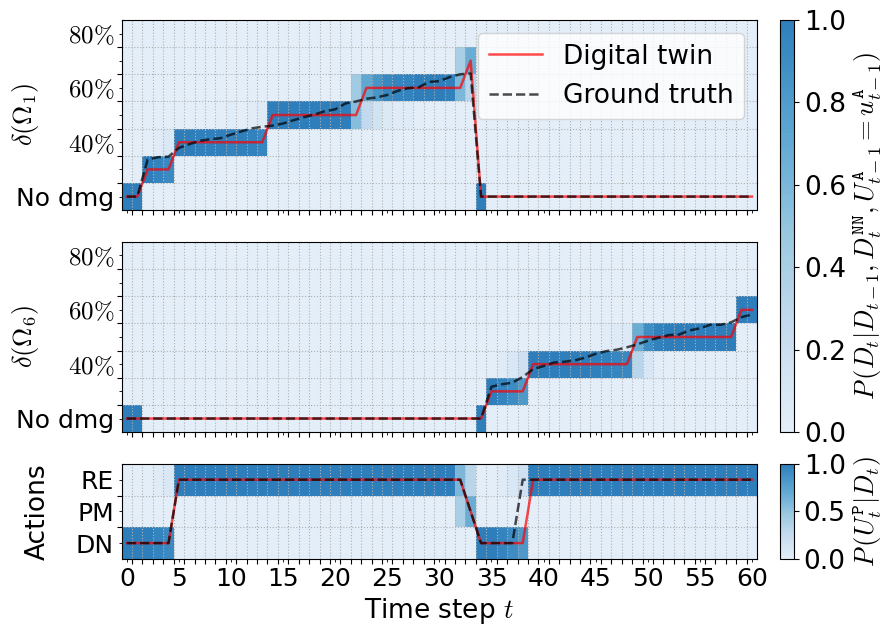

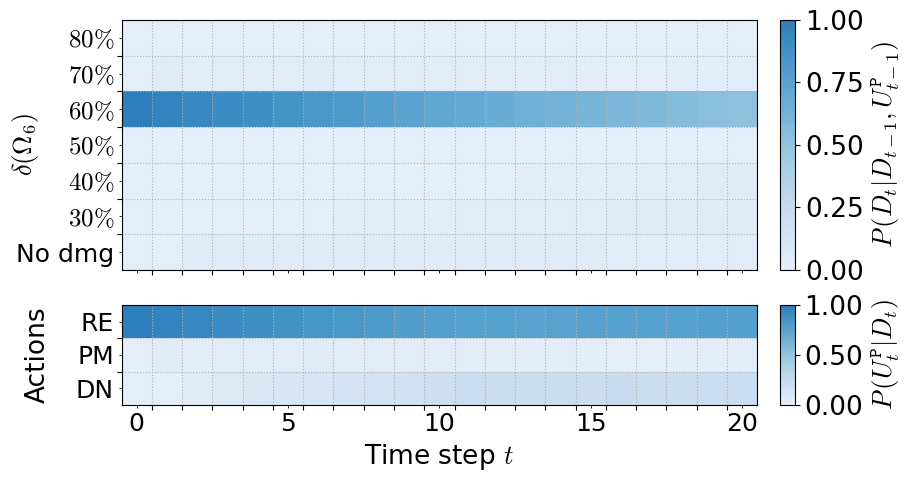

In [10]:
import warnings
warnings.filterwarnings('ignore')

if __name__ == '__main__':

    # number of classes in the dataset
    n_class = 7
    # damage level discretization adopted to describe different states, related
    # to the same damage location but different damage severity
    d_level_discr = 0.1
    # number of intervals resulting from the discretization of damage level
    n_level_step = 6
    # path containing the data to be loaded
    path_data = './data/'
    # paths containing the models to be loaded
    path_classifier = './models/Classifier_total/model'
    path_regressors = [
        f'./models/Level_Regressor_{i}/model' for i in range(1, n_class)
    ]
    # load the trained SHM models
    classifier = keras.models.load_model(Path(path_classifier))
    regressors = [keras.models.load_model(Path(path_regressors[i])) for i in range(n_class-1)]
    # load the statistics used to normalize the damage levels for each regressor
    statistics_level = np.load(Path(f'{path_data}statistics_level.npy'))
    # load the confusion matrix previously obtained by evaluating the capabilities
    # of the SHM models to assess the digital state
    conf_mat_dt = np.load(Path(f'{path_data}confusion_digital_estimate.npy'))
    # add small quantity to avoid zero division during normalization
    conf_mat_dt = conf_mat_dt + 1e-5
    # normalizes the cpd table so that each column of values sums to 1
    conf_mat_dt = normalize_cpd(conf_mat_dt)

    # array of all the possible states
    possible_states = np.array(["0;0.0"])
    for i in range(1,n_class):
        for j in range(n_level_step):
            l = np.around(j*d_level_discr + 0.3, n_level_step-1)
            possible_states = np.append(
                possible_states, np.array([f"{str(i)};{str(l)}"]), 0
            )

    # array of all the possible actions
    possible_actions = np.array(["do_nothing", "perfect_repair", "restrict_operations" ])

    ##########################################################################
    # simulation

    setup_bridge = GetSetup(states_list=possible_states,
                           actions_list=possible_actions,
                           n_class=n_class,
                           n_level_step=n_level_step,
                           conf_mat_dt=conf_mat_dt)

    transitions = setup_bridge.get_transitions(p_nothing=0.10,
                                               p_restricted=0.03)

    planner_bridge = Planner(states_list=possible_states,
                             actions_list=possible_actions,
                             gamma=0.9,
                             transitions=transitions)

    planner_bridge.compute_policy(maxit=1000, tol=1e-4)
    cpd_d_to_u = planner_bridge.policy.T

    graph_structure, digital_subgraph, list_cpd_graph, list_cpd_subgraph = \
        setup_bridge.get_graph(cpd_d_to_u,
                               transitions)

    bridge = PhysicalAsset(path_data, degradation_law="stochastic")
    bridge.generate_observations()
    digital_bridge = DigitalAsset(classifier=classifier,
                                  regressors=regressors,
                                  statistics_level=statistics_level,
                                  d_level_discr=d_level_discr,
                                  cpd=conf_mat_dt)

    graph_bridge = Graph(physical_asset=bridge,
                         digital_asset=digital_bridge,
                         states_list=possible_states,
                         actions_list=possible_actions,
                         planner=planner_bridge)

    graph_bridge.assemble_graph(graph_structure=graph_structure,
                                cpd_list=list_cpd_graph,
                                digital_subgraph=digital_subgraph,
                                list_cpd_subgraph=list_cpd_subgraph,
                                plot=True)

    graph_bridge.simulate(n_steps=60, n_samples=100, n_obs=10)

    plotting_bridge = Plot(graph_bridge,'./plotters/3_act')
    plotting_bridge.plot_history_all_together()
    plotting_bridge.plot_prediction_all_together(n_steps=20, n_samples=1000)